The quality of synthetic data is paramount to that of the trained model.

In [1]:
import numpy as np
import scipy
from scipy import interpolate, constants, stats
import matplotlib.pyplot as plt
import math
import time
from pathlib import Path
import jax
from jax import vmap, jit
from jax import numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
import orbax.checkpoint as ocp

Make sure to set the following configurations correctly.

In [2]:
DATA_DIR = Path("../data")
CKPT_DIR = Path("/checkpoints")

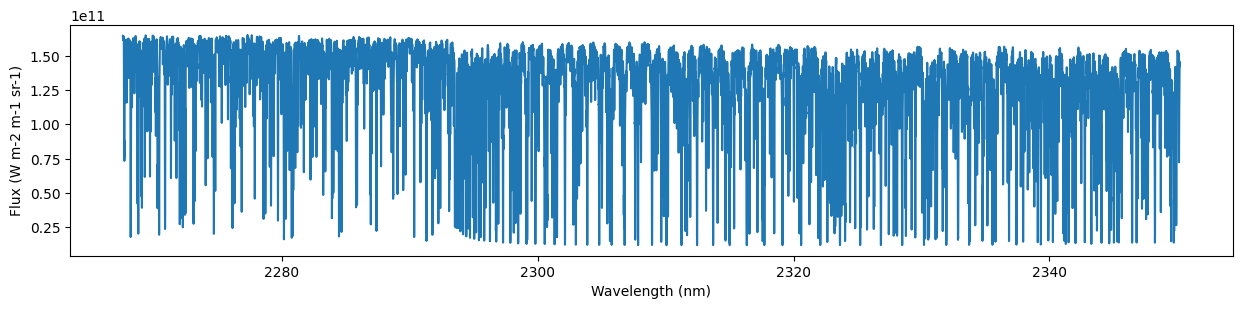

In [3]:
wMod = np.load(DATA_DIR / "wmod.npy")
fMod = np.load(DATA_DIR / "fmod.npy")

plt.figure(figsize=(15, 3))
plt.plot(wMod, fMod)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Flux (W m-2 m-1 sr-1)")
plt.show()

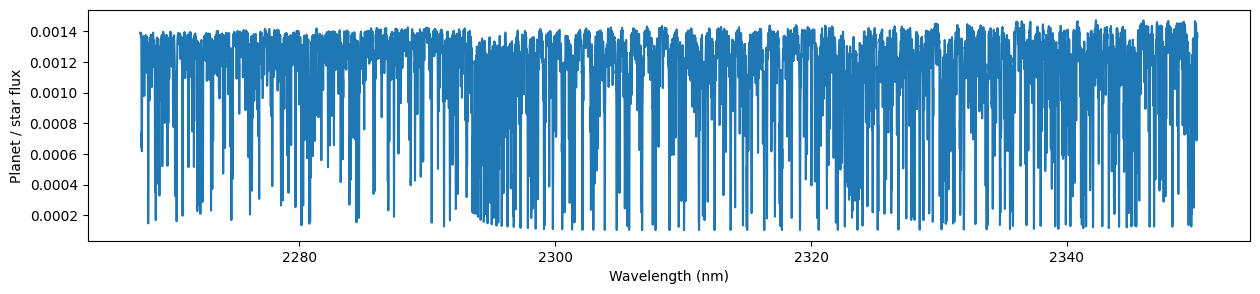

In [4]:
def blackbody(T,wl):
	h = constants.Planck
	c = constants.speed_of_light
	k = constants.Boltzmann
	c1 = 2 * np.pi * h * c * c
	c2 = h * c / k
	val = c2 / wl / T
	return c1 / (wl ** 5 * (np.exp(val) - 1))

def scale_model(fMod, wlen):
	Rp = 1.38					 # Southworth et al. (2010)
	Rstar = 1.162			 # Torres et al. (2008)
	RR = (Rp * 6.99E7 / (Rstar * 6.957E8)) ** 2
	Fstar = np.pi * blackbody(6065, wlen * 1E-9)
	flux = fMod / Fstar
	flux *= RR
	flux = jnp.asarray(flux)
	return flux

extraScaling = 2
fModScaled = scale_model(fMod * np.pi, wMod) * extraScaling

plt.figure(figsize=(15,3))
plt.plot(wMod, fModScaled)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Planet / star flux")
plt.show()

In [5]:
def generate_ph(min_ph, max_ph, num=59):
	ph = jnp.linspace(min_ph, max_ph, num=num)
	return ph

## NOTE: These parameters are for the exoplanet HD 209458 b and they are tuned to real CRIRES observations
## of this object under realistic conditions. The observing block is about 5 hours long
Kp = 145.9							 # Planet max. RV (km/s)
air = jnp.load(DATA_DIR / "air.npy") # Airmass variation (from real observations)
rvel = jnp.load(DATA_DIR / "rvel.npy") # Systemic + barycentric radial velocity (km/s)
wlen_regr = jnp.load(DATA_DIR / "wlen_regr.npy")
spec = jnp.load(DATA_DIR / "algn.npy")

The following functions create and visualize a synthetic planetary signal given the relevant parameters.

The observed planet emits a spectrum which depends on the composition of its atmosphere. This is then subject to a Doppler shift which is determined by the radial component of the velocity of the planet towards or away from the Earth. As it follows its cirular orbit around the star, the radial component of its velocity towards or away from the Earth changes and so does the Doppler shift of its spectrum.

The planetary radial velocity is determined mostly by its circular orbit around the star and, to a lesser extent, by the stellar primary (systemic and barycentric) velocity.

Each image shown corresponds to an order of the planetary signal. The vertical axis represents time and orbital phase. The horizontal axis corresponds to wavelengths and thus covers different values for each order. The lines of the planetary signal are tilted and somewhat curved due to the radial velocity (and therefore Doppler shift) varying over time.

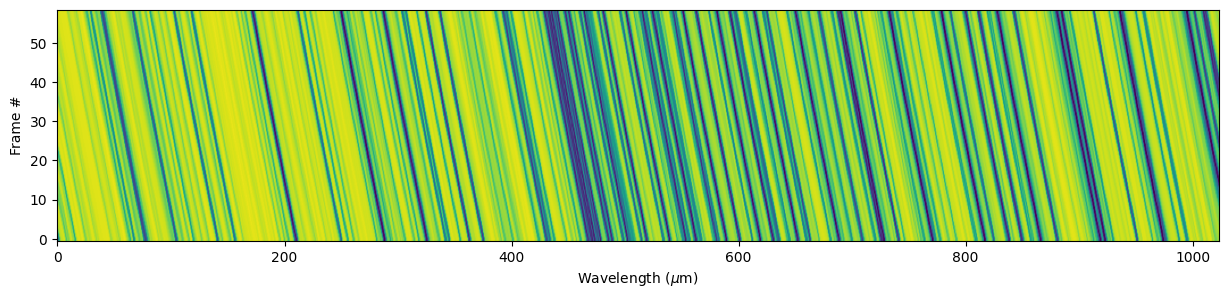

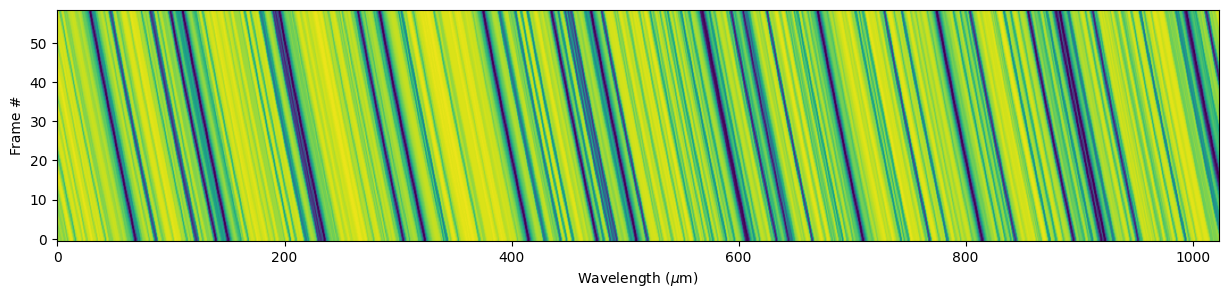

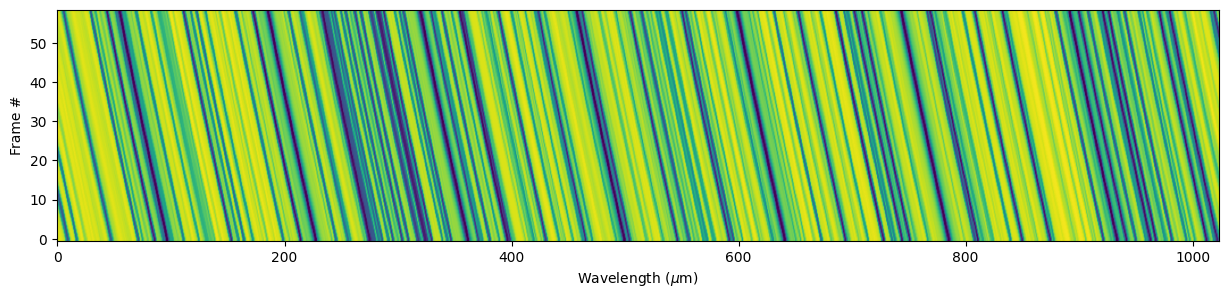

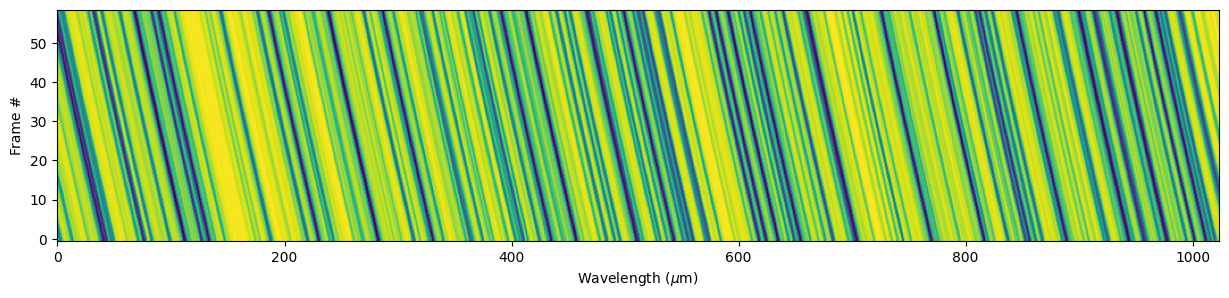

0

In [6]:
def create_planet_signal(wMod, fMod1, ph, rvel, Kp):
	no, nx = wlen_regr.shape
	nf = ph.size
	Vpl = rvel + Kp * np.sin(2 * np.pi * ph)
	cs = interpolate.splrep(wMod, fMod1)
	planet_signal = np.ones((no, nf, nx))
	c = constants.speed_of_light
	shift = 1 - Vpl * 1000 / c
	for io in range(no):
		for j in range(nf):
			wMod1 = wlen_regr[io] * shift[j]
			planet_signal[io, j] += interpolate.splev(wMod1, cs)
	planet_signal = jnp.asarray(planet_signal)
	return planet_signal

def plot_signal(wlen, signal):
	no, nf, nx = signal.shape
	v0 = signal.min()
	v1 = signal.max()
	for io in range(no):
		plt.figure(figsize=(15, 3))
		#lims = [wlen[io, 0] / 1E3, wlen[io, -1] / 1E3, ph[0], ph[-1]]
		plt.imshow(signal[io], origin="lower", aspect="auto", vmin=v0, vmax=v1)
		plt.xlabel("Wavelength ($\mu$m)")
		plt.ylabel("Frame #")
		plt.show()
	return 0

ph = generate_ph(0.50673796, 0.57780502)	 # Orbital phases (from real observations) (tr)
planet_signal = create_planet_signal(wMod, fModScaled, ph, rvel, Kp)
plot_signal(wMod, planet_signal)

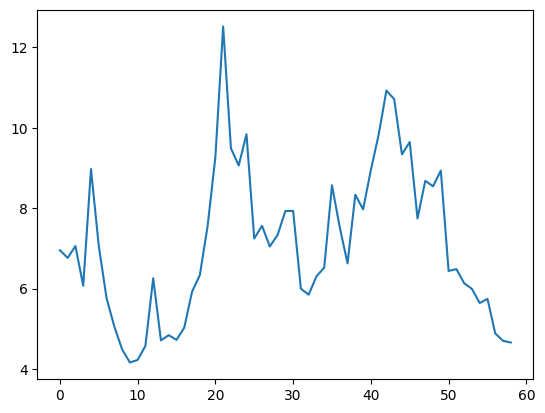

In [7]:
def random_process(size, p):
	random = np.random.normal(size=size)
	v = random[0] / np.sqrt(1 - p ** 2)
	sequence = [v]
	for r in random[1:]:
		v = v * p + r
		sequence.append(v)
	sequence = jnp.asarray(sequence)
	sequence *= jnp.sqrt(1 - p ** 2)
	return sequence

def random_pwv(size, dt=1, pace=1e4, sigma=0.667, scale=3.294):
	pace /= dt
	p = pace / (pace + 1)
	sequence = random_process(size, p)
	sequence *= sigma
	pwv = jnp.exp(sequence)
	pwv *= scale
	return pwv

timespan = 5 * 60 * 60

pwv = random_pwv(59, dt=timespan / 59)

plt.plot(pwv)
plt.show()

As light from the observed planetary system traverses the terrestrial athmosphere, some of it is absorbed.

(4, 59, 1024)


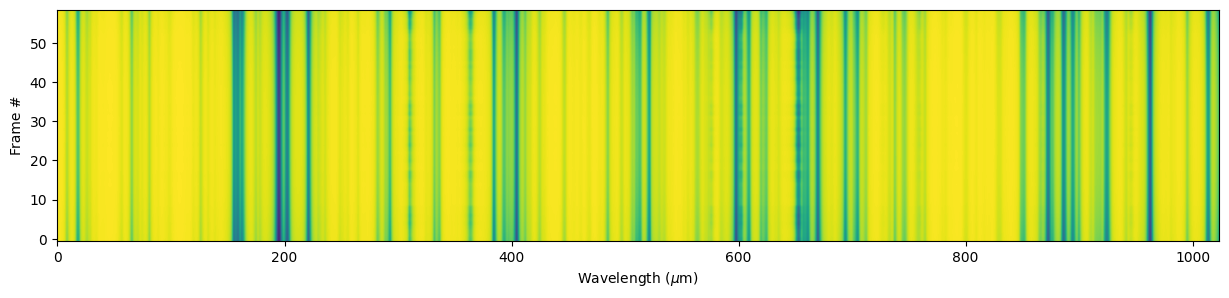

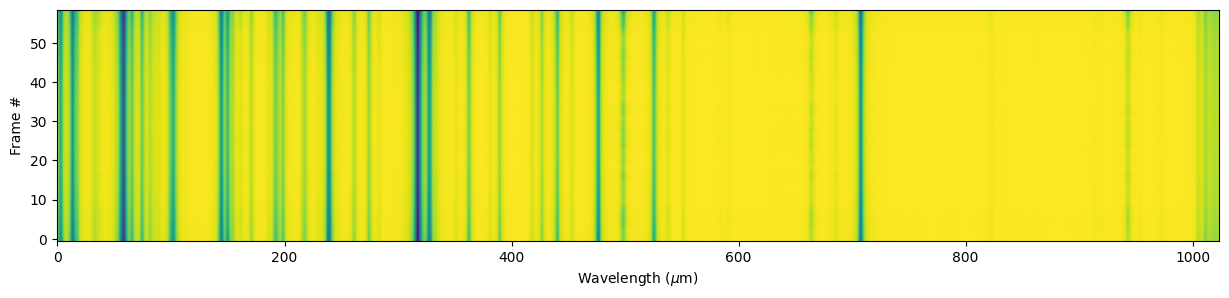

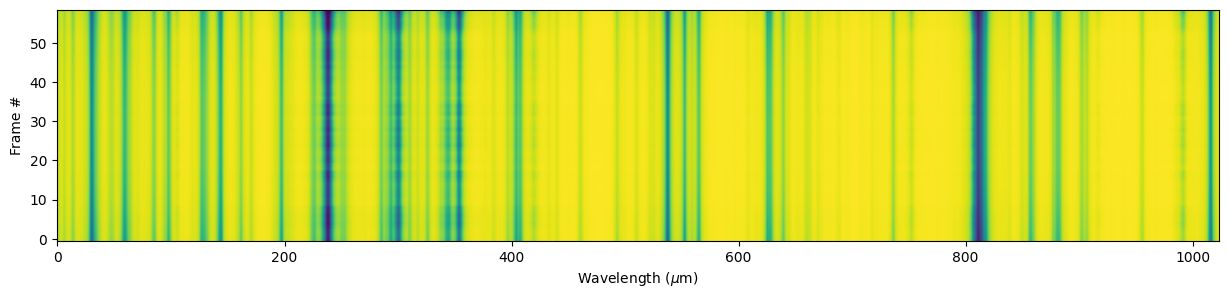

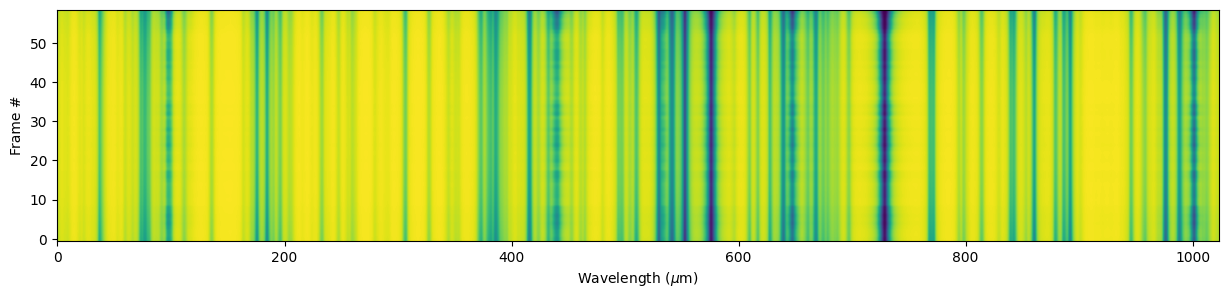

0

In [8]:
def get_gaussian_ip(res, wl): # Gaussian instrumental profile.
	lamPix = (wl[1:] + wl[:-1]) / 2
	dlamPix = wl[1:] - wl[:-1]
	dvPix = jnp.mean(dlamPix / lamPix)
	dvFWHM = 1 / res
	fwhmPix = dvFWHM / dvPix
	sigmaPix = 0.5 * fwhmPix / jnp.sqrt(2 * jnp.log(2))
	hker = int(4 * fwhmPix)
	xker = jnp.arange(-hker, hker + 1)
	yker = jnp.exp(-0.5 * (xker / sigmaPix) ** 2)
	yker /= yker.sum()
	return yker, hker

def get_telluric_spectrum(air0, pwv0, coeffFit):
	pwvFitLog = jnp.linalg.multi_dot((jnp.stack((pwv0, jnp.ones(pwv0.size)), axis=1), coeffFit)) #np.array([pwv0, 1]) @ coeffFit  # Right PWV, airmass = 1
	telFitLog = pwvFitLog * air0[:, None]
	telFit = jnp.exp(telFitLog)
	return telFit

def broaden_spectrum(flux, wlen):
	ker, hk = get_gaussian_ip(100000, wlen)
	fluxBroad = scipy.signal.convolve2d(flux, ker[None], mode="valid")
	return wlen[hk : -hk], fluxBroad

telGrid = jnp.load(DATA_DIR / "trGrid_crires.npy")
telGrid = telGrid.at[telGrid == 0].set(1E-20)

_, nxx = telGrid.shape

wl0 = 2200
wlGrid = jnp.exp(4e-6 * jnp.arange(nxx) + jnp.log(wl0))

assert wlGrid.min() > 1000

pwv_values = jnp.asarray([0.5, 1.0, 1.5, 2.5, 3.5, 5.0, 7.5, 10.0, 20.0])

grid = jnp.log(telGrid)

coeffFit = jnp.polyfit(pwv_values, grid, 1)

timespan = 5 * 60 * 60

def generate_tell():
    pwv_sequence = random_pwv(air.size, dt=timespan / air.size)
    telSpecModelR = get_telluric_spectrum(air, pwv_sequence, coeffFit)
    wlClipped, telSpecInstrumentR = broaden_spectrum(telSpecModelR, wlGrid)
    tell = jnp.stack([interpolate.splev(wlen_regr, interpolate.splrep(wlClipped, telSpec)) for telSpec in telSpecInstrumentR], axis=1)
    return tell

tell = generate_tell()

print(tell.shape)
planet_signal = planet_signal * tell
plot_signal(wMod, planet_signal)

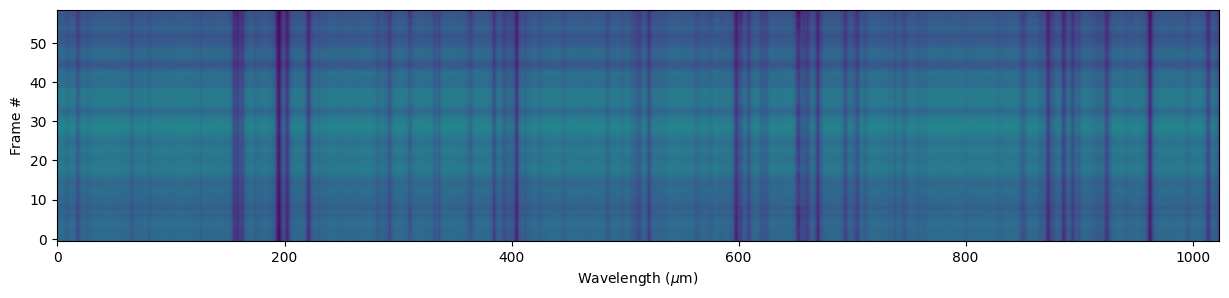

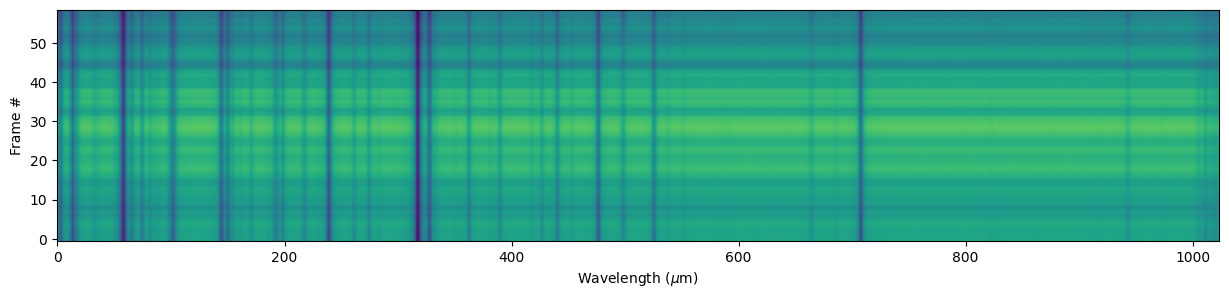

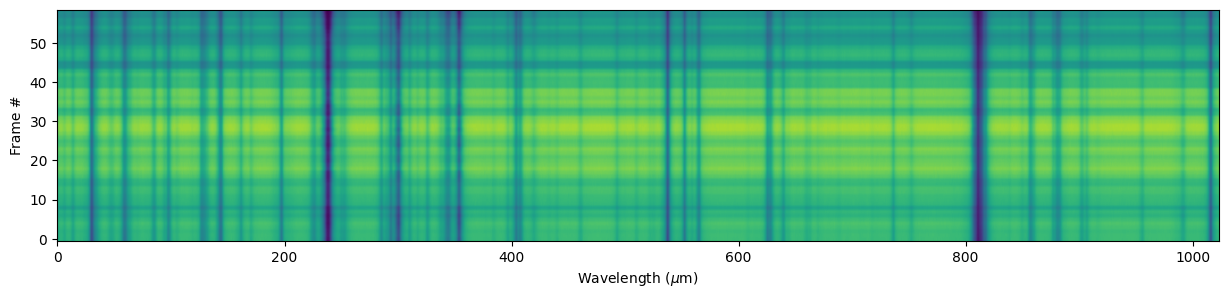

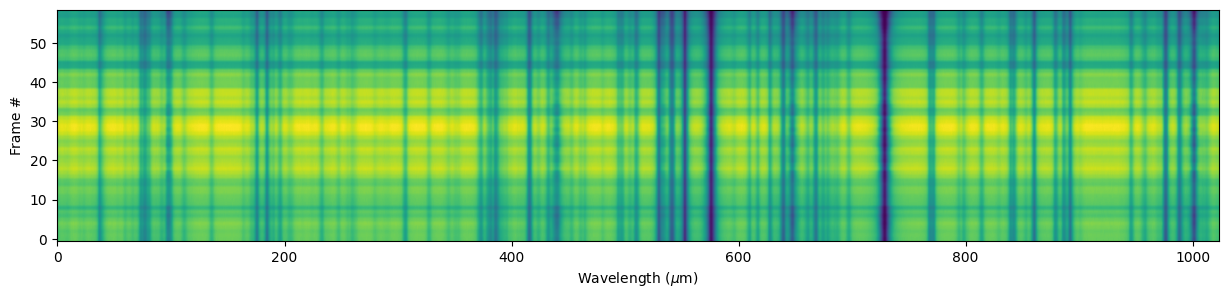

0

In [9]:
@jit
def add_noise(key, spcFake):
	expTime = 150.0 * 2.0			 # Twice the actual exposure time
	detGain = jnp.asarray([6.97, 6.89, 6.92, 7.27])
	spcNorm = expTime * detGain[:, None, None] * spec	 # Counts -> e-
	vsort = jnp.sort(spcNorm)
	cnt = (vsort[..., 856] + vsort[..., 857]) / 2	 # Median counts per spec
	spcFake *= cnt[..., None]
	# Adding Gaussian noise
	phNoiseAmp = jnp.sqrt(spcFake)
	noise = jax.random.normal(key, shape=spcFake.shape)
	noise *= phNoiseAmp
	spcFake += noise
	spcFake /= (expTime * detGain[:, None, None])
	return spcFake

key = jax.random.PRNGKey(44)

key, noise_key = jax.random.split(key)

signal = add_noise(noise_key, planet_signal)
plot_signal(wMod, signal)

The code below generates a synthetic observation.

A pool of planetary and telluric signals is generated. This can be used multiple times, improving efficiency, and can be refreshed when appropriate in order to still have enough randomness.

To synthetize an observation, a planetary and a telluric signal are selected from the available pool and noise is added.

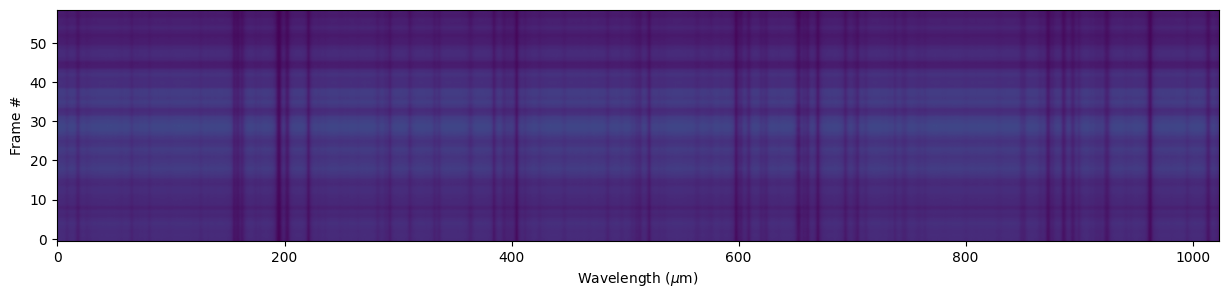

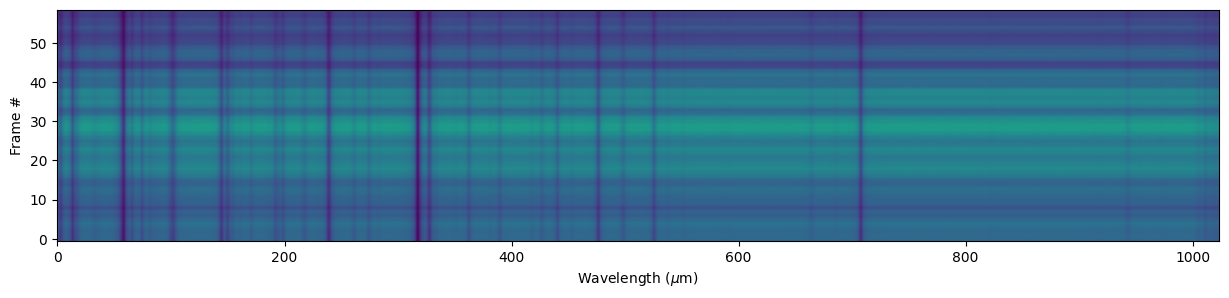

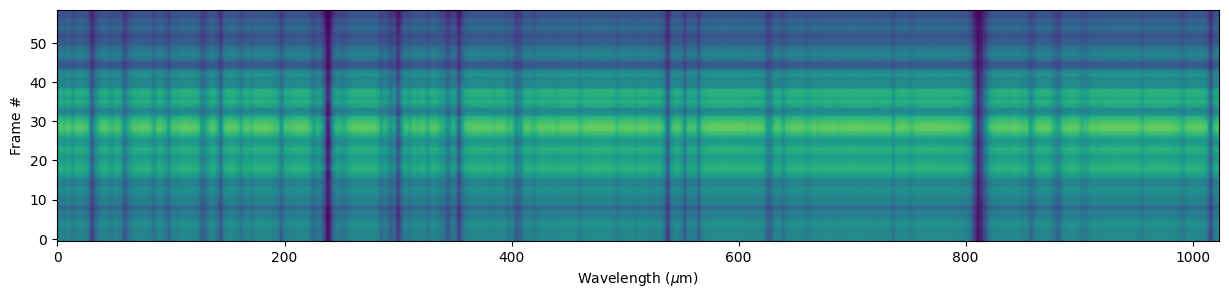

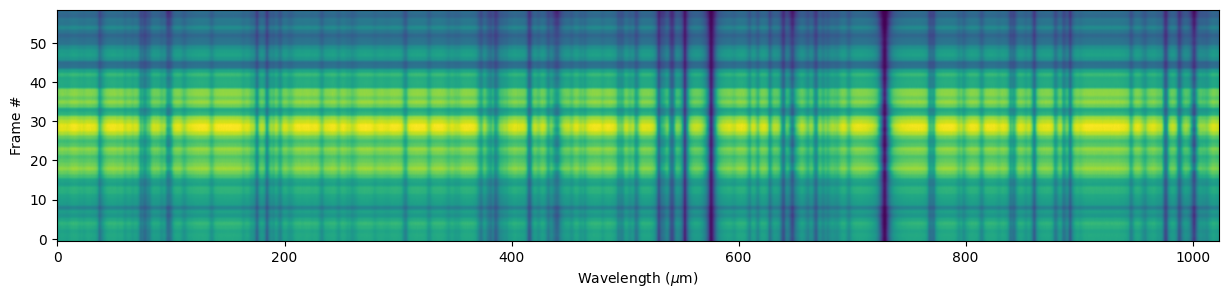

0

In [10]:
ph_offset = 0.07106706
ph_0_min = 0.35
ph_0_max = 0.65

fModScaled = scale_model(fMod * np.pi, wMod) * extraScaling

def random_planet_signals(key, num=50):
	ph_0 = jax.random.uniform(key, shape=(num,), minval=ph_0_min, maxval=ph_0_max - ph_offset)
	ph1 = generate_ph(ph_0, ph_0 + ph_offset).T
	ph2 = jnp.flip(ph1, axis=1)
	ph = jnp.concat((ph1, ph2))
	signals = []
	for i in range(num * 2):
		signal = create_planet_signal(wMod, fModScaled, ph[i], rvel, Kp)
		signals.append(signal)
	signals = jnp.asarray(signals)
	return signals

def random_tell_signals(key, num=100):
	tells = []
	for _ in range(num):
		tell = generate_tell()
		tells.append(tell)
	tells = jnp.asarray(tells)
	return tells

@jit
def gen_signals(key, planet_signal_pool, tell_signal_pool):
	planet_key, tell_key, noise_key = jax.random.split(key, num=3)

	planet_signal = jax.random.choice(planet_key, planet_signal_pool)
	tell_signal = jax.random.choice(tell_key, tell_signal_pool)

	obs_pos_signal = add_noise(noise_key, signal)
	obs_neg_signal = add_noise(noise_key, tell_signal)
	return obs_pos_signal, obs_neg_signal, planet_signal

key, planet_key, tell_key, signal_key = jax.random.split(key, num=4)

planet_signal_pool = random_planet_signals(planet_key, num=2)
tell_signal_pool = random_tell_signals(tell_key, num=2)

obs_signal, _, _ = gen_signals(key, planet_signal_pool, tell_signal_pool)
plot_signal(wMod, obs_signal)

Below the generation of a batch of training data is described. This determines most of what there is to know about the desired behavior of the model which is to be trained.

The batch is represented as an array of inputs to and one of corresponding desired outputs from the neural architecture. A number of positive observed signals, corresponding planetary signals and negative observed signals is generated. From here, individual orders of each signal are processed independently.

Each input sample is a matrix representing an order of an observed signal. A planetary signal is present in half of the samples. The desired output corresponding to a positive input sample is the same order of the original planetary signal. The desired output corresponding to a negative input sample is a null matrix.

The shape of the input and of the desired output data is the same. An extra dimension of size 1 is added to both, as it will be handy for processing in the convolutional layers. Each input sample and positive desired output is normalized so as to have a mean of 0 and a standard deviation of 1.

In [11]:
gen_signals_vmapped = vmap(gen_signals, in_axes=(0, None, None))

def z_scores(x):
	axis = range(1, x.ndim)
	std = x.std(axis=axis, keepdims=True)
	mean = x.mean(axis=axis, keepdims=True)
	x = (x - mean) / std
	return x

@jit
def prepare_batch(pos_x, neg_x, pos_y):
	neg_y = jnp.zeros(neg_x.shape)
	x = jnp.concatenate((neg_x, pos_x))
	x = jnp.reshape(x, (-1, *x.shape[2:]))
	x = z_scores(x)
	pos_y = z_scores(pos_y)
	y = jnp.concatenate((neg_y, pos_y))
	y = jnp.reshape(y, (-1, *y.shape[2:]))
	x = x[..., None]
	y = y[..., None]
	return x, y

def gen_batch(key, num, planet_signal_pool, tell_signal_pool):
	keys = jax.random.split(key, num=num)
	obs_pos_signal, obs_neg_signal, planet_signal
	pos_x, neg_x, pos_y = gen_signals_vmapped(keys, planet_signal_pool, tell_signal_pool)
	x, y = prepare_batch(pos_x, neg_x, pos_y)
	return x, y

x, y = gen_batch(key, 5, planet_signal_pool, tell_signal_pool)

The loss function, the initialization and the optimizer for the model are defined below.

As a loss function, the model will use the half mean squared error. As an optimizer, the model will use Adam. Please, note that at least two variations exist in commonly used frameworks. The code belows uses the [Optax](https://optax.readthedocs.io/en/latest/api/optimizers.html#optax.adam) implementation.

In [12]:
@jit
def train_step(state, batch):
	x, y = batch
	def loss_fn(params):
		preds = state.apply_fn({ "params": params }, x)
		loss = optax.l2_loss(preds, targets=y).mean()
		return loss
	grad_fn = jax.value_and_grad(loss_fn)
	loss, grads = grad_fn(state.params)
	state = state.apply_gradients(grads=grads)
	return state, loss

def create_train_state(module, rng, learning_rate, momentum):
	params = module.init(rng, signal.reshape(*signal.shape, 1))["params"]
	tx = optax.adam(learning_rate)
	return train_state.TrainState.create(apply_fn=module.apply, params=params, tx=tx)

The *Lincoln* layer, defined below, processes a three-dimensional tensor representing a matrix of pixels with a certain depth. The corresponding output will have the same width and height as the input and a depth determined by the given hyperparameters. Each pixel will be the concatenation of a linear projection of its corresponding row and column in the input. The tensor will, therefore, have duplicated values across each row and column.

It should be noted that the layer independently processes a batch of samples at once.

In [34]:
class Lincoln(nn.Module):
	lin: int
	coln: int

	@nn.compact
	def __call__(self, x):
		h = x.shape[1]
		w = x.shape[2]
		a = nn.Conv(features=self.lin, kernel_size=(h, 1), padding="VALID")(x)
		b = nn.Conv(features=self.coln, kernel_size=(1, w), padding="VALID")(x)
		a = jnp.repeat(a, h, axis=1)
		b = jnp.repeat(b, w, axis=2)
		x = jnp.concatenate((a, b), axis=-1)
		return x

Here the neural architecture which will be used is declared.

The input sample represents an order of an observed signal and has an additional one-sized depth dimention, which comes handy for processing. The desired output is the corresponding order of the planetary signal or, if it isn't present, a null matrix and it will also have an additional dimension. Input and output data have the same shape.

The architecture is some kind of deep feed-forward convolutional neural network which also contains Lincoln layers and a skip connection. Latent feature tensors produced by hidden layers have the same width and height as the input and the output.

An all-one channel is added to the input sample to help the following (convolutional) layers detect borders and padding. The tensor is then processed and expanded in depth by a convolutional layer which, because of the all-one channel, does not need to have a bias. The network continues with various convolutional and Lincoln layers. ReLU is used as an activation function throughout. In order to preserve enough information about each pixel, the output of each Lincoln layer is combined back with its own input, resulting in a deeper tensor. This still contains duplicated data along each row and column. Passing it directly to a convolutional layer with a large kernel would result in reduntant operations. Instead, it first processed by a one-by-one convolutional layer, which also reduces its depth. The network also contains an identity skip connection. The last convolutional layer produces a tensor of depth 1 and is not followed by any element-wise activation. As a final step, the mean of the sample is subtracted from all cells, resulting in a zero-meaned output.

The input sample represents an order of an observed signal and has an additional one-sized dimention, which comes handy for processing. An all-one layer is added to help the following (convolutional) layers detect borders and padding. The next layer is a convolutional layer and does not need to use any bias because the middle value of its kernel corresponding to the (padded) all-one layer will always receive a 1. The network continues with various convolutional layers, which also pad the tensor so as not to reduce its size, as well as *Lincoln* layers. ReLU is used as the activation function of hidden layers. The output of each Lincoln layer is combined back with its own input, resulting in a deeper tensor. This is done in order to preserve information about the individual pixel. The result is a tensor which still contains duplicated data along each row and column (due to the Lincoln layer). Passing this directly to a convolutional layer with a large kernel would result in operations on duplicated data. To address this, the network uses $1 \times 1$ convolutional layers which reduce the depth of the tensor. The mean value is subtracted so that it becomes zero.

It should be noted that the neural network independently processes a batch of samples at once.

In [35]:
class CNN(nn.Module):
	@nn.compact
	def __call__(self, x):
		ones = jnp.ones(x.shape)
		x = jnp.concatenate((x, ones), axis=-1)
		x = nn.Conv(features=64, kernel_size=(11, 11), use_bias=False)(x)
		x = nn.leaky_relu(x)
		abe = Lincoln(64, 64)(x)
		abe = nn.leaky_relu(abe)
		x = jnp.concatenate((abe, x), axis=-1)
		x = nn.Conv(features=64, kernel_size=(1, 1))(x)
		residual = x
		x = nn.leaky_relu(x)
		x = nn.Conv(features=64, kernel_size=(11, 11))(x)
		x = nn.leaky_relu(x)
		abe = Lincoln(64, 64)(x)
		abe = nn.leaky_relu(abe)
		x = jnp.concatenate((abe, x), axis=-1)
		x = nn.Conv(features=64, kernel_size=(1, 1))(x)
		x = x + residual
		x = nn.leaky_relu(x)
		x = nn.Conv(features=64, kernel_size=(11, 11))(x)
		x = nn.leaky_relu(x)
		abe = Lincoln(64, 64)(x)
		abe = nn.leaky_relu(abe)
		x = jnp.concatenate((abe, x), axis=-1)
		x = nn.Conv(features=64, kernel_size=(1, 1))(x)
		x = nn.leaky_relu(x)
		x = nn.Conv(features=1, kernel_size=(11, 11))(x)
		x -= x.mean(axis=(1, 2), keepdims=True)
		return x

In [36]:
learning_rate = 0.00001
momentum = 0.9
num_spectra = 4

key, init_key = jax.random.split(key)

jax.config.update("jax_debug_nans", True)

cnn = CNN()
state = create_train_state(cnn, init_key, learning_rate, momentum)

options = ocp.CheckpointManagerOptions(max_to_keep=20)
mngr = ocp.CheckpointManager(CKPT_DIR, options=options)

epoch = 0

In [37]:
start_total_time = time.time()

key, planet_key, tell_key = jax.random.split(key, num=3)
planet_signal_pool = random_planet_signals(planet_key)
tell_signal_pool = random_tell_signals(tell_key)

prev_epoch_loss = math.inf

while True:
	mngr.save(epoch, args=ocp.args.StandardSave(state))
	epoch_loss = 0
	start_epoch_time = time.time()
	for _ in range(100):
		key, batch_key = jax.random.split(key)
		batch = gen_batch(batch_key, num_spectra, planet_signal_pool, tell_signal_pool)
		state, loss = train_step(state, batch)
		epoch_loss += loss
	if epoch % 10 == 0:
		mngr.wait_until_finished()
	epoch_loss /= 100
	epoch_time = time.time() - start_epoch_time
	total_time = time.time() - start_total_time
	print(epoch, "-", epoch_loss, "-", epoch_time, "-", total_time)
	if epoch % 16 == 0:
		key, planet_key = jax.random.split(key)
		planet_signal_pool = random_planet_signals(planet_key)
		tell_signal_pool = random_tell_signals(tell_key)
	elif epoch % 16 == 8:
		key, tell_key = jax.random.split(key)
		tell_signal_pool = random_tell_signals(tell_key)
	if epoch_loss > prev_epoch_loss * 1.25 or (epoch > 100 and epoch_loss > 0.245):
		print("Restoring checkpoint", epoch - 5)
		state = mngr.restore(epoch - 5, args=ocp.args.StandardRestore(state))
		learning_rate /= 2
		print("New learning rate:", learning_rate)
		tx = optax.adam(learning_rate)
		state = train_state.TrainState.create(apply_fn=state.apply_fn, params=state.params, tx=tx)
	prev_epoch_loss = epoch_loss
	
	epoch += 1

KeyboardInterrupt: 

In [ ]:
key, _ = jax.random.split(key)

spectrum, _ = gen_spectrum(key, sequences, tells, plaent=False)
spectrum = spectrum.reshape((*spectrum.shape, 1))
spectrum = normalize_spectra(spectrum)
pred1 = cnn.apply({ "params": state.params }, spectrum)
pred1 = pred1.reshape(pred1.shape[:-1])

spectrum, sign = gen_spectrum(key, sequences, tells)
spectrum = spectrum.reshape((*spectrum.shape, 1))
spectrum = normalize_spectra(spectrum)
pred2 = cnn.apply({ "params": state.params }, spectrum)
pred2 = pred2.reshape(pred2.shape[:-1])

spectrum = spectrum.reshape(spectrum.shape[:-1])

pred = pred2 - pred1

plot_matrix(wFake, pred2, ph)

print(pred1.std())
print(pred2.std())